# 1. ICLL

This notebook explores the implementation of ICLL (Imbalanced Classification via Layered Learning [1]). The three steps to its implementation are:

- Dimensionality reduction for cluster build-up
- ICLL
- Explainability: understand the original drivers for RSV positivity from the reduced features


[1]: Cerqueira, V., Torgo, L., Branco, P., & Bellinger, C. (2023). Automated imbalanced classification via layered learning. Machine Learning, 112(6), 2083-2104.

In [205]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [204]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

In [6]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [7]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [47]:
df1 = rsv_predictors_df_v2[selected_features_v2]
df1.shape, df1.columns
# Very interesting to discuss:
# all demographic features are EXCLUDED

((86058, 21),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'month_of_the_test',
        'multiple_tests', 'BPA', 'BPAI', 'RSV_test_result'],
       dtype='object'))

## 1. Dimensionality reduction via FAMD

In [48]:
# Initialize the FAMD model and transform data to the new components
random_seed = 42
n_components = 3

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(df1)

df_transformed = famd.transform(df1)

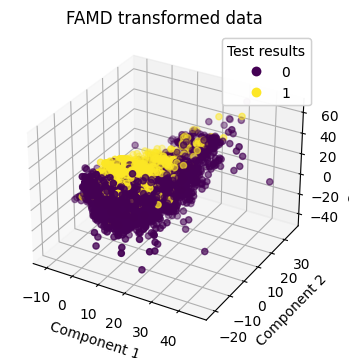

In [49]:
# Plot of the newly created data, indicating the presence of positive and negative tests

# Ensure both df1 and df_transformed present the same records in the same order
df1 = df1.sort_index()
df_transformed = df_transformed.sort_index()
assert all(df1.index == df_transformed.index), "The indices of df1 and df_transformed do not match."

df_transformed['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

# Plot of the transformed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_transformed[0], df_transformed[1], df_transformed[2], c=df_transformed['RSV_test_result'], cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Test results")
ax.add_artist(legend1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('FAMD transformed data')
plt.show()


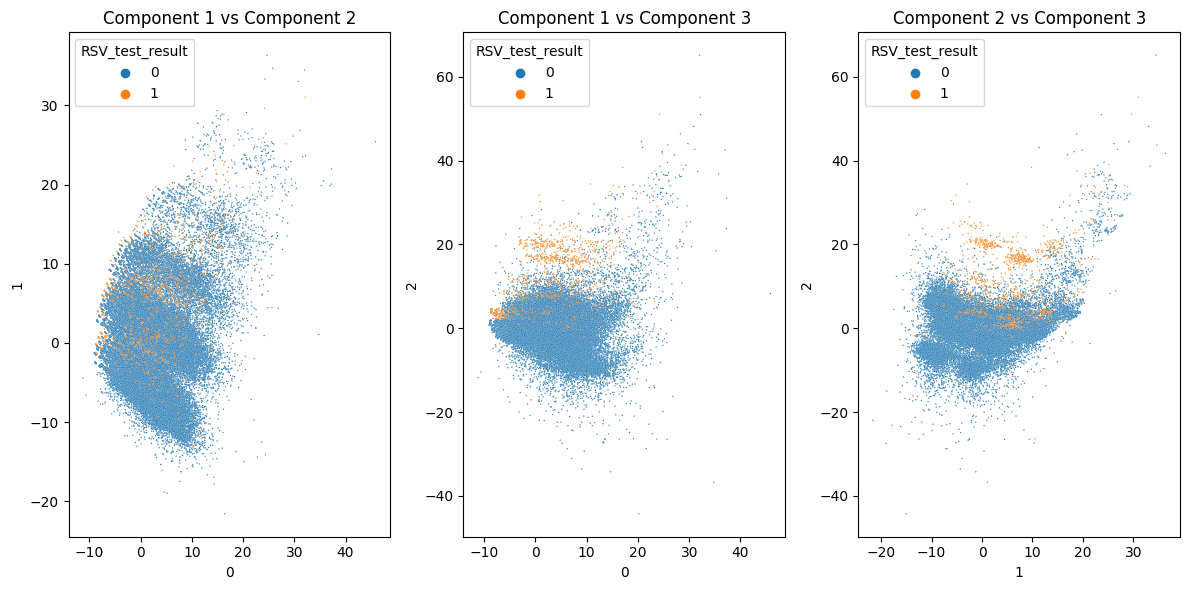

In [50]:
# For clarity, let us plot the 3 different planes
f, axes = plt.subplots(1, 3, figsize=(12, 6))

# Two-dimensional plots
sns.scatterplot(data=df_transformed, x=0, y=1, hue='RSV_test_result', ax=axes[0], s = 1)
axes[0].set_title('Component 1 vs Component 2')

sns.scatterplot(data=df_transformed, x=0, y=2, hue='RSV_test_result', ax=axes[1], s = 1)
axes[1].set_title('Component 1 vs Component 3')

sns.scatterplot(data=df_transformed, x=1, y=2, hue='RSV_test_result', ax=axes[2], s = 1)
axes[2].set_title('Component 2 vs Component 3')

plt.tight_layout()

In the newly created components, positive and negative test results seem to be very much separable. Let us try a simple initial model to evaluate this assumption.

In [65]:
df_modelling = df_transformed[[0,1,2,'RSV_test_result']]

X = df_modelling.drop(['RSV_test_result'], axis=1)
y = df_modelling['RSV_test_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42,
                                                        stratify= y)

In [52]:
cost_sensitive = False
if cost_sensitive:
    weight_dict = {0: 1, 1: 5}
    model_class = RandomForestClassifier(class_weight= weight_dict, random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None, random_state= random_seed)
    
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='binary', pos_label = 1)
n_cv_folds = 5

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train, y_train = y_train)

Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.629550779493368


Optimal threshold: 0.29
Optimal f1: 0.6720160481444333


AUC Score: 0.9489431744067334
Precision / Positive predictive value: 0.7188841201716738
Specificity: 0.9921467537917391
Recall / sensitivity: 0.6308851224105462
Negative predictive value: 0.9882957124089334
Accuracy: 0.9810016267720195
F-1: 0.6720160481444333
Precision-Recall AUC: 0.7228053037006135


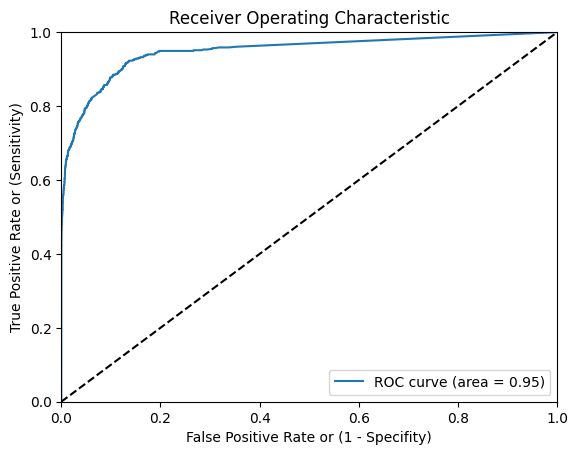

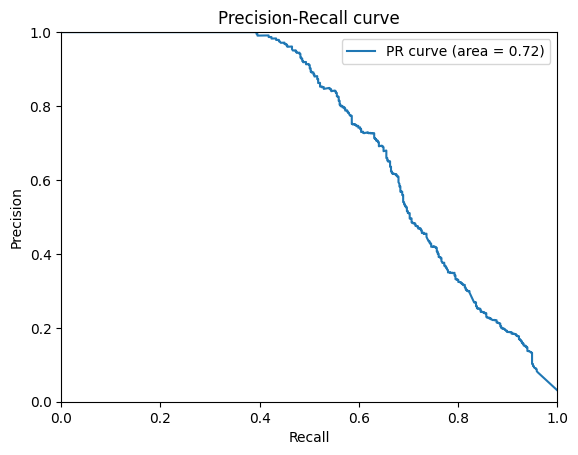

In [53]:
# y_test is brought back to the Negative/Positive notation for consistency
aux_y_test = ['Positive' if numeric_label == 1 else 'Negative' for numeric_label in y_test]

optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test, y_test = aux_y_test)

__,__,__,__,__,__,f1,__ = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test, y_test = aux_y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True, print_pr = True)


The use of this newly-created components already produces a high performing model. Let us explore the use of ICLL for better understanding of the data.

## 2. ICLL implementation
ICLL presents two stages:
- First, the clustering of records
- Second, the build-up of 'layers' according to these clusters. Some clusters are defined as 'easy to predict' and others are the decision boundaries'

In [75]:
db = DBSCAN(eps=0.8, min_samples=5).fit(df_transformed[[0, 1, 2]]) 
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 131
Estimated number of noise points: 4563


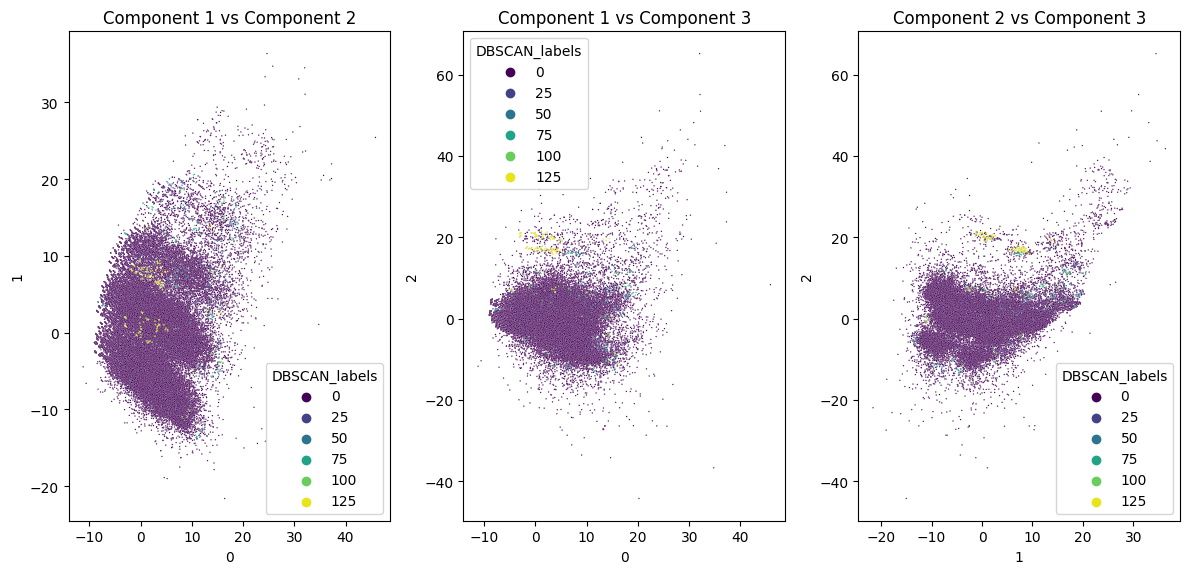

In [134]:
df_transformed['DBSCAN_labels'] = labels

plot_3FMDA_planes(df = df_transformed, hue_target = 'DBSCAN_labels', palette = 'viridis')

-----------
Total number of positive records: 2654
Number of positives in Clustered: 1947
Number of positives in Noise: 707


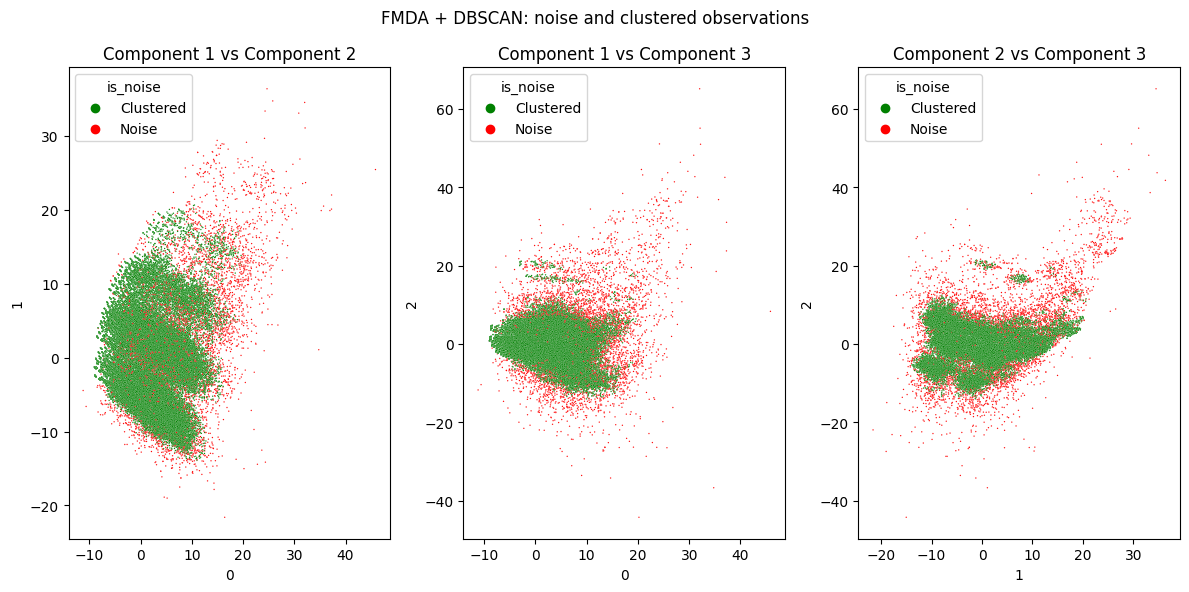

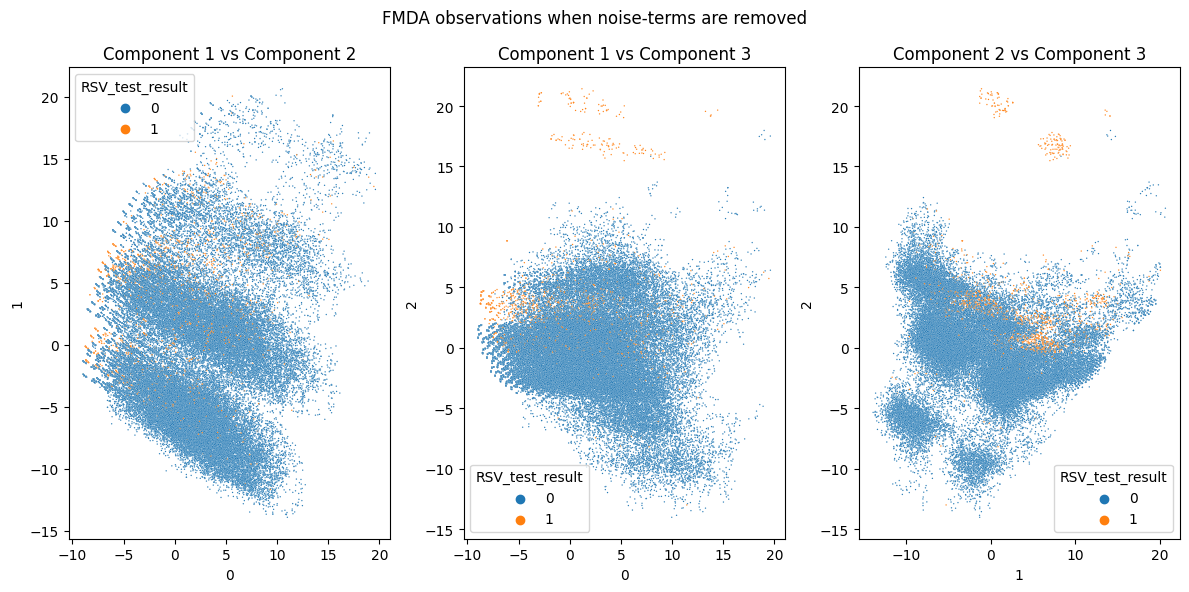

In [135]:
# Create a binary variable indicating whether each point is noise or not.
df_transformed['is_noise'] = df_transformed['DBSCAN_labels'].apply(lambda x: 'Noise' if x == -1 else 'Clustered')

# Evaluate the number of positive records in the clustered and noise regions:
print('-----------')
total_pos = df_transformed['RSV_test_result'].value_counts()[1]
print(f'Total number of positive records: {total_pos}')
for c in df_transformed['is_noise'].unique():
    aux_df = df_transformed.loc[df_transformed['is_noise'] == c]
    pos = aux_df['RSV_test_result'].value_counts()[1]
    print(f'Number of positives in {c}: {pos}')

# Plot of noise and clustered observations
plot_3FMDA_planes(df = df_transformed, hue_target = 'is_noise', palette = {"Clustered": "g", "Noise": "r"}, main_title = 'FMDA + DBSCAN: noise and clustered observations')

# Plot the labels when the noise observations are removed:
df_no_noise = df_transformed.loc[df_transformed['is_noise'] != 'Noise']
plot_3FMDA_planes(df = df_no_noise, hue_target = 'RSV_test_result', main_title = 'FMDA observations when noise-terms are removed')

In [154]:
count_pos = 0
count_neg = 0
count_mix = 0
for cl in df_transformed['DBSCAN_labels'].unique():
    # print(f'Cluster {cl}')
    aux_df = df_transformed.loc[df_transformed['DBSCAN_labels'] == cl]
    neg = aux_df['RSV_test_result'].value_counts().iloc[0]
    
    if len(aux_df['RSV_test_result'].value_counts()) > 1:
        pos = aux_df['RSV_test_result'].value_counts().iloc[1]
        pos_to_neg = pos / neg
        # print(f'Positive to negative ratio: {pos_to_neg}')
        count_mix += 1
        df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Mixed'

    else: 
        dominant_label = aux_df['RSV_test_result'].value_counts().index[0]
        if dominant_label == 1:
            # print('Fully positive')
            df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Positive'
            count_pos += 1
        elif dominant_label == 0:
            # print('Fully negative')
            df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Negative'
            count_neg += 1
print('-------------')
print('Results of DBSCAN clustering:')
print(f'\n# fully positive clusters: {count_pos}')
pos_obs = df_transformed['mixed_or_unique'].value_counts()['Positive']
print(f'observacions on fully positive: {pos_obs}')

print(f'\n# fully negative clusters: {count_neg}')
neg_obs = df_transformed['mixed_or_unique'].value_counts()['Negative']
print(f'observacions on fully negative: {neg_obs}')

print(f'\n# mixed clusters: {count_mix}')
mix_obs = df_transformed['mixed_or_unique'].value_counts()['Mixed']
print(f'observacions on mixed clusters: {mix_obs}')

-------------
Results of DBSCAN clustering:

# fully positive clusters: 22
observacions on fully positive: 203

# fully negative clusters: 84
observacions on fully negative: 682

# mixed clusters: 26
observacions on mixed clusters: 85173


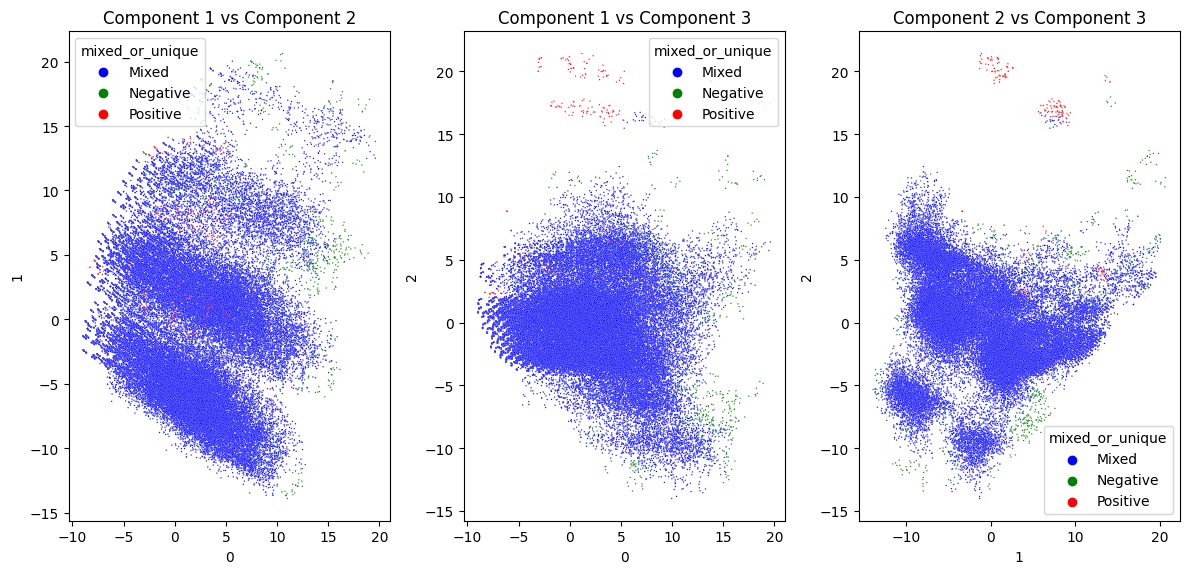

In [160]:
df_no_noise = df_no_noise.assign(mixed_or_unique=df_transformed.loc[df_transformed['is_noise'] != 'Noise', 'mixed_or_unique'].values)
plot_3FMDA_planes(df = df_no_noise, hue_target = 'mixed_or_unique', palette = {'Mixed': 'b', 'Positive': 'r', 'Negative': 'g'})

In [ ]:
# Now the number of clusters seem satisfactory, we can build-up the layers

In [178]:
class LayeredLearning:
    def __init__(self, model_l1, model_l2):
        self.model_l1 = model_l1
        self.model_l2 = model_l2
        self.mixed_arr = np.array([])

    def fit(self, X: pd.DataFrame, y: np.ndarray, cluster_labels):
        assert isinstance(X, pd.DataFrame)
        X = X.reset_index(drop=True)

        if isinstance(y, pd.Series):
            y = y.values

        self.mixed_arr = self.cluster_to_layers(cluster_labels, y)

        y_l1 = y.copy()
        y_l1[self.mixed_arr] = 1

        X_l2 = X.loc[self.mixed_arr, :]
        y_l2 = y[self.mixed_arr]

        self.model_l1.fit(X, y_l1)
        self.model_l2.fit(X_l2, y_l2)

    @staticmethod
    def cluster_to_layers(cluster_labels: np.ndarray, y: np.ndarray) -> np.ndarray:
        maj_cls, min_cls, both_cls = [], [], []
        unique_clusters = np.unique(cluster_labels)

        for clst in unique_clusters:
            cluster_indices = np.where(cluster_labels == clst)[0]
            y_clt = y[cluster_indices]

            if len(Counter(y_clt)) == 1:
                if y_clt[0] == 0:
                    maj_cls.extend(cluster_indices)
                else:
                    min_cls.extend(cluster_indices)
            else:
                both_cls.extend(cluster_indices)

        both_cls = np.array(both_cls)
        min_cls = np.array(min_cls)

        both_cls_ind = np.unique(np.concatenate([both_cls, min_cls])).astype(int)

        return both_cls_ind
    
    def predict(self, X):
        """
        Predicting new instances
        """

        yh_l1, yh_l2 = self.model_l1.predict(X), self.model_l2.predict(X)

        yh_f = np.asarray([x1 * x2 for x1, x2 in zip(yh_l1, yh_l2)])

        return yh_f

    def predict_proba(self, X):
        """
        Probabilistic predictions
        """

        yh_l1_p = self.model_l1.predict_proba(X)
        try:
            yh_l1_p = np.array([x[1] for x in yh_l1_p])
        except IndexError:
            yh_l1_p = yh_l1_p.flatten()

        yh_l2_p = self.model_l2.predict_proba(X)
        yh_l2_p = np.array([x[1] for x in yh_l2_p])

        yh_fp = np.asarray([x1 * x2 for x1, x2 in zip(yh_l1_p, yh_l2_p)])

        return yh_fp


In [179]:
df_ICLL = df_no_noise[[0, 1, 2, 'RSV_test_result']]

X = df_ICLL.drop('RSV_test_result', axis = 1)
y = df_ICLL['RSV_test_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42,
                                                        stratify= y)

db2 = DBSCAN(eps=0.8, min_samples=5).fit(X_train) 
cluster_labels = db2.labels_

In [208]:
clf1 = LogisticRegression(class_weight= None, random_state= random_seed)
clf2 = RandomForestClassifier(class_weight= None, random_state= random_seed)

layered_model = LayeredLearning(model_l1=clf1, model_l2=clf2)
layered_model.fit(X_train, y_train, cluster_labels)

In [210]:
aux_y_test = ['Positive' if numeric_label == 1 else 'Negative' for numeric_label in y_test]

optimal_threshold = find_optimal_moving_threshold(model = layered_model, X_test = X_test, y_test = aux_y_test, ICLL = True)
__,__,__,__,__,__,f1,__ = calculate_performance_metrics_rsv(trained_model = layered_model, X_test = X_test, y_test = aux_y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False, print_pr = False,
                                                         ICLL = True)

Optimal threshold: 0.36
Optimal f1: 0.631578947368421


AUC Score: 0.9288815299426884
Precision / Positive predictive value: 0.7608695652173914
Specificity: 0.9958516656191074
Recall / sensitivity: 0.5398457583547558
Negative predictive value: 0.9888285589465143
Accuracy: 0.9849684029695074
F-1: 0.631578947368421
Precision-Recall AUC: 0.665051319400837
